<a href="https://colab.research.google.com/github/MariaPetrovskaya/Data-Science-demo/blob/main/Toxic_comments%2C_compare_models_BERT_and_TF_IDF_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание проекта

**Проект с использованием BERT**

**Описание проекта**
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75. 

# Загрузка библиотек и некоторые инсталляции, которые потребовали при работе в Colab и на Anaconda

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#conda update conda

In [ ]:
from google.colab import drive
from google.colab import files

In [ ]:
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer# 

In [ ]:
from nltk.corpus import wordnet
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from pymystem3 import Mystem

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
pip install gdown


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gdown

In [ ]:
pip install datasets transformers seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.2 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=f11d433fc46ecf2986b896ed80c505b9ebfd3f8537117a9483dc20ec7b74bf35
  Stored in directory: /root/.cache/pip/wheels/ad/5c/ba/05fa33fa5

In [ ]:
import transformers

print(transformers.__version__)

4.26.1


In [ ]:
from transformers import BertTokenizer #TFBertForSequenceClassification
#from transformers import InputExample, InputFeatures

#model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
from transformers import AutoModel, AutoTokenizer

In [ ]:
import sys

In [ ]:
pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import spacy

**Результат** Загрузка всех библиотек

# Загрузка и знакомство с данными 

In [ ]:
uploaded = files.upload()

Saving toxic_comments.csv to toxic_comments.csv


In [ ]:
df = pd.read_csv('toxic_comments.csv', index_col=0)
data = df.copy()
display (data.head(5))
print (data.info())
print (data.duplicated().sum())
display (data.sample(5))

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None
0


,text,toxic
132673,REDIRECT Talk:Kateri(Katary) hydro-electric sy...,0
68698,"""\nThere was no consensus there that BLP appli...",0
5843,I will be writing an e-mail regardless with al...,1
94154,Discography \n\nShouldn't there be a section o...,1
125817,FAGGGGG\nYOU ARE A HUUUUUUUGE FAGGOT,1


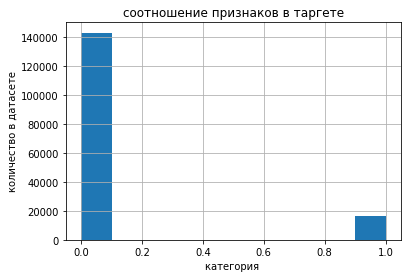

In [ ]:

data['toxic'].hist()

plt.xlabel("категория ")
plt.ylabel("количество в датасете")
plt.title("соотношение признаков в таргете")
plt.show()


**Результат** видно, что в выборке существенно преобладает ответ "0" - сбалансированности классов в таргете нет

# Работа с данными в BERT

In [ ]:
model_name = "unitary/toxic-bert" # модель BERT обученная на токсичных текстах, f1~0.95

model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#data.drop(columns=['Unnamed: 0'], inplace=True)
data = data[:159200] # Небольшой костыль!

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
#device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
data1 = data.sample(4500).reset_index(drop=True)

In [ ]:
#data = data.sample(3000).reset_index(drop=True)

**Результат** датасет был слишком большой для работы при имеющихся мощностях, создана выборка из 4500 строк и сохранена как новая переменная. 

In [ ]:

target = data1['toxic']
print(target.shape)

(4500,)


In [ ]:
tokenized = data1['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

**Результат** разделено на токены 

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
#configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
#model = BertModel(configuration)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#config = transformers.BertConfig.from_pretrained('bert-base-uncased')
#model = BertForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
#model = transformers.BertModel.from_pretrained('bert-base-uncased')

**Результат** подобрана модель и конфигурация из библиотек  BERT подходящая для данного датасета 

<div class="alert alert-info">Изменено: заменено на специализированную модель toxic BERT</div>

In [ ]:
batch_size = 100

In [ ]:
#Этот код запускать не надо, он считался в Colab около 4 часов, я выгрузила его результаты дальше как переменные

batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())
        del batch
        del attention_mask_batch
        del batch_embeddings



  0%|          | 0/45 [00:00<?, ?it/s]

**Результат** создание embeddings с помощью BERT 


In [ ]:
features = np.concatenate(embeddings)


**Результат** создание признаков 

**адрес папки где размещены данные**: https://


In [ ]:
print('features:', features.shape)

features: (4500, 768)


In [ ]:
df_features = pd.DataFrame(data=features)

In [ ]:
df_features.to_csv(r'features.csv', sep=',')

In [ ]:
target.to_csv(r'target.csv', sep=',')

In [ ]:
files.download('target.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Загрузка результатов расчета признаков



In [ ]:
uploaded = files.upload()

Saving features (1).csv to features (1) (1).csv


In [ ]:
features = pd.read_csv('features (1) (1).csv', index_col=0)
display (features.sample(5))

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
2317,-0.439869,-0.814066,0.731047,-0.467802,0.919573,0.364395,0.192493,0.004638,-0.221582,-0.529035,...,-0.888048,-1.140610,0.312283,-0.717837,0.055621,0.782522,-0.328507,-0.739547,0.695418,0.281415
3310,-0.377149,-0.815013,0.722103,-0.539463,0.860976,0.668126,0.362263,0.213477,-0.559485,-0.105543,...,-0.622946,-0.536391,0.300671,-0.404307,-0.450916,0.288696,-0.509076,-0.380354,0.830879,0.228978
2525,-0.609821,-0.829580,0.595246,-0.507766,1.096649,0.083648,-0.105848,0.010391,-0.483179,-0.742062,...,-0.340451,-1.283999,0.300177,-0.692511,0.142390,0.752811,-0.514598,-0.772084,0.361346,0.090891
925,-0.607883,-0.847725,0.581621,-0.549705,1.017848,0.337406,-0.040772,0.001620,-0.436940,-0.602486,...,-0.658252,-1.139683,0.371621,-0.637351,0.147397,0.813871,-0.488821,-0.685728,0.599489,0.075678
930,-0.400575,-0.795693,0.677925,-0.094113,0.577009,0.708213,0.303320,0.244169,-0.406314,-0.068468,...,-0.692666,-0.480908,0.270719,-0.623918,-0.430975,0.043766,-0.237760,-0.338661,0.975684,0.708694


In [ ]:
uploaded = files.upload()

Saving target (2).csv to target (2) (1).csv


In [ ]:
target = pd.read_csv('target (2) (1).csv', index_col=0)
display (target.sample(5))

,toxic
1568,0
3418,0
1168,0
951,0
1905,1


In [ ]:
target = target['toxic']

In [ ]:
print('features shape:', features.shape)

print('target shape:', target.shape)

features shape: (4500, 768)
target shape: (4500,)


**Результат** признаки и таргет сохранены как файл, далее повторно загружены как файл 

In [ ]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.40, random_state=12345, stratify = target)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.50, random_state=12345, stratify = target_valid_test )
print('features_train shape:', features_train.shape)
print('features_valid shape:', features_valid.shape)
print('features_test shape:', features_test.shape)
print('target_train shape:', target_train.shape)
print('target_valid shape:', target_valid.shape)
print('target_test shape:', target_test.shape)

features_train shape: (2700, 768)
features_valid shape: (900, 768)
features_test shape: (900, 768)
target_train shape: (2700,)
target_valid shape: (900,)
target_test shape: (900,)


In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)
print("Accuracy модели логистической регрессии:", accuracy)
print('F1:', f1_score(target_valid,predictions))

Accuracy модели логистической регрессии: 0.9888888888888889
F1: 0.9473684210526315


**Результат** на простой модели логистической регресии достигнута метрика 0, 94, существенно выше требующейся


In [ ]:
%%time
best_model = None
best_result = 0
for depth in range(1, 100):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    print(model, '|', 'глубина=',depth,'|', result)
    print("F1:", f1_score(target_valid, predicted_valid))
    print("max_depth =", depth, ": ", end='')
    if result > best_result:
        best_model = model
        best_result = result  
print("максиально достигнутый F1:", best_result)
print('Cамая эффективная модель - best_model',best_model)
    


DecisionTreeClassifier(class_weight='balanced', max_depth=1, random_state=12345) | глубина= 1 | 0.8598130841121496
F1: 0.8598130841121496
max_depth = 1 : DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=12345) | глубина= 2 | 0.8866995073891626
F1: 0.8866995073891626
max_depth = 2 : DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=12345) | глубина= 3 | 0.9137055837563451
F1: 0.9137055837563451
max_depth = 3 : DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=12345) | глубина= 4 | 0.9175257731958762
F1: 0.9175257731958762
max_depth = 4 : DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345) | глубина= 5 | 0.9270833333333333
F1: 0.9270833333333333
max_depth = 5 : DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=12345) | глубина= 6 | 0.9263157894736842
F1: 0.9263157894736842
max_depth = 6 : DecisionTreeClassifier(class_weight='balanced', max_depth=7, random_state=12

**Результат** достигнута нужная метрика, максиально достигнутый F1: 0.9411764705882354
Cамая эффективная модель - best_model DecisionTreeClassifier(class_weight='balanced', max_depth=14,
                       random_state=12345)

In [ ]:
%%time
best_model_f = None
best_result_f = 0
for depth in range(2, 22, 2):
    for est in range(50, 351, 50):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth,class_weight='balanced') 
        model.fit(features_train, target_train) 
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) 
        print(model, '|', 'est=',est,'|', 'depth=',depth,'|', result)
        print("F1:", f1_score(target_valid, predicted_valid))
        if result > best_result_f:
            best_model_f = model
            best_result_f = result 
        
print("максимально достгнутый F1:", best_result_f)
print('Cамая эффективная модель - best_model',best_model_f)

RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=50,
                       random_state=12345) | est= 50 | depth= 2 | 0.9246231155778896
F1: 0.9246231155778896
RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=12345) | est= 100 | depth= 2 | 0.9346733668341709
F1: 0.9346733668341709
RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=150,
                       random_state=12345) | est= 150 | depth= 2 | 0.9306930693069306
F1: 0.9306930693069306
RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=200,
                       random_state=12345) | est= 200 | depth= 2 | 0.9306930693069306
F1: 0.9306930693069306
RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=250,
                       random_state=12345) | est= 250 | depth= 2 | 0.9253731343283582
F1: 0.9253731343283582
RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=300,
                       r

**Результат** Необходимая метрика достигнута, F1: 0.9473684210526315
Cамая эффективная модель - best_model RandomForestClassifier(class_weight='balanced', max_depth=6, random_state=12345)

In [ ]:
print ('Сравнение результатов разных моделей при испольваниее toxic BERT')
print()
print('F1 на обычной модели логистический регрессии:', f1_score(target_valid,predictions))
print()
print ('на модели дерева решений с подбором гиперпараметров')
print("максиально достигнутый F1:", best_result)
print('Cамая эффективная модель - best_model',best_model)
print ()
print ('на модели случайного леса с подбором гиперпараметров')
print("максимально достгнутый F1:", best_result_f)
print('Cамая эффективная модель - best_model',best_model_f)



Сравнение результатов разных моделей при испольваниее toxic BERT

F1 на обычной модели логистический регрессии: 0.9473684210526315

на модели дерева решений с подбором гиперпараметров
максиально достигнутый F1: 0.9473684210526315
Cамая эффективная модель - best_model RandomForestClassifier(class_weight='balanced', max_depth=6, random_state=12345)

на модели случайного леса с подбором гиперпараметров
максимально достгнутый F1: 0.9473684210526315
Cамая эффективная модель - best_model RandomForestClassifier(class_weight='balanced', max_depth=6, random_state=12345)


**Выводы: специализированная toxic BERT дает существенно высокие показатели F1 на всех моделях**

# Работа с данными на основе расчетов TF-IDF

In [ ]:
%%time
corpus = data['text'].values
nltk.download('stopwords')

stopwords = set(nltk_stopwords.words('english'))

CPU times: user 22.2 ms, sys: 1.85 ms, total: 24 ms
Wall time: 46 ms


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def clear_text (text):
    text_m = re.sub(r'[^a-zA-Z ]', ' ', text)
    text_m = text_m.split()
    text_m = " ".join(text_m)
    test_lower = text_m.lower()
    text_wo_stop_w = [i for i in test_lower.split() if i not in stopwords]
    lemm_text = nlp(" ".join(text_wo_stop_w))
        
    return " ".join([token.lemma_ for token in lemm_text])
            
print("Исходный текст:", corpus[0])
#print("Очищенный и лемматизированный текст:", lemmatize(clear_text(corpus[0])))


Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [ ]:
data['text_clear'] = data['text'].apply(clear_text)

In [ ]:
display (data['text_clear'].sample(5))

149096    history model second generation production his...
65996     whatever fact may wiki need online source refe...
27382                     upload image article help require
154086    john herrington anyone gather much information...
27475                                               october
Name: text_clear, dtype: object

In [ ]:
display (data.sample(5))

,text,toxic,text_clear
91151,you just wait \n\nyour death is near,1,wait death near
85616,Of course you're right — the hurly-burly of th...,0,course right hurly burly editing process bear ...
80084,"""\n I acknowledge it was disruptive, but I sto...",0,acknowledge disruptive stopped stop harass sto...
15312,Sounds good to me. Shall we vote on it?,0,sound good shall vote
43737,"""\nOkay, I'm going to get a meal and then get ...",0,okay go get meal get back emerson template


In [ ]:
uploaded = files.upload()

Saving clean_text.csv to clean_text.csv


In [ ]:
data.to_csv(r'clean_text.csv', sep=',')

In [ ]:
files.download('clean_text.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
uploaded = files.upload()

Saving clean_text.csv to clean_text.csv


In [ ]:
data = pd.read_csv('clean_text.csv')

In [ ]:
train_valid, test = train_test_split(data, random_state=12345, stratify = data['toxic'], test_size=0.20)
train, valid = train_test_split(train_valid, random_state=12345, stratify = train_valid['toxic'], test_size=0.25)

In [ ]:
print('train shape:', train.shape)
print('valid shape:', valid.shape)
print('test shape:', test.shape)

train shape: (95574, 3)
valid shape: (31859, 3)
test shape: (31859, 3)


In [ ]:
%%time
corpus_train = train['text_clear'].values
nltk.download('stopwords')

stopwords = set(nltk_stopwords.words('english'))

CPU times: user 3.46 ms, sys: 986 µs, total: 4.44 ms
Wall time: 4.03 ms


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%%time
corpus_valid = valid['text_clear'].values
nltk.download('stopwords')

stopwords = set(nltk_stopwords.words('english'))

CPU times: user 880 µs, sys: 0 ns, total: 880 µs
Wall time: 890 µs


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%%time
corpus_test = test['text_clear'].values
nltk.download('stopwords')

stopwords = set(nltk_stopwords.words('english'))

CPU times: user 56 µs, sys: 1.99 ms, total: 2.04 ms
Wall time: 1.72 ms


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%%time
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
train_tf_idf = count_tf_idf.fit_transform(corpus_train) 
valid_tf_idf = count_tf_idf.transform(corpus_valid)
test_tf_idf = count_tf_idf.transform(corpus_test)

print("Размер матрицы test_tf_idf:", train_tf_idf.shape)
print("Размер матрицы valid_tf_idf:", valid_tf_idf.shape)
print("Размер матрицы test_tf_idf:", test_tf_idf.shape)

Размер матрицы test_tf_idf: (95574, 114424)
Размер матрицы valid_tf_idf: (31859, 114424)
Размер матрицы test_tf_idf: (31859, 114424)
CPU times: user 5.23 s, sys: 72.6 ms, total: 5.3 s
Wall time: 5.37 s


**Результат** созданы признаки

In [ ]:
features_train_tf_idf = train_tf_idf
target_train_tf_idf =  train['toxic']
features_valid_tf_idf = valid_tf_idf
target_valid_tf_idf =  valid['toxic']
features_test_tf_idf = test_tf_idf
target_test_tf_idf =  test['toxic']

print('features_train_tf_idf shape:', features_train_tf_idf.shape)
print('features_valid_tf_idf shape:', features_valid_tf_idf.shape)
print('features_test_tf_idf shape:', features_test_tf_idf.shape)
print('target_train_tf_idf shape:', target_train_tf_idf.shape)
print('target_valid_tf_idf shape:', target_valid_tf_idf.shape)
print('target_test_tf_idf shape:', target_test_tf_idf.shape)

features_train_tf_idf shape: (95574, 114424)
features_valid_tf_idf shape: (31859, 114424)
features_test_tf_idf shape: (31859, 114424)
target_train_tf_idf shape: (95574,)
target_valid_tf_idf shape: (31859,)
target_test_tf_idf shape: (31859,)


**Результат** разделено на тренировочную и тестовую выборки

In [ ]:
%%time
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_train_tf_idf, target_train_tf_idf)
predictions_tf_idf = model.predict(features_valid_tf_idf)
accuracy_tf_idf = accuracy_score(target_valid_tf_idf, predictions_tf_idf)
print("Accuracy модели логистической регрессии:", accuracy_tf_idf)
print('F1:', f1_score(target_valid_tf_idf,predictions_tf_idf))



Accuracy модели логистической регрессии: 0.9562447032235789
F1: 0.7410846953937593
CPU times: user 1.2 s, sys: 897 ms, total: 2.1 s
Wall time: 1.11 s


**Результат** метрика F1: 0.74 близкая к нужной


In [ ]:
%%time
best_model_tf_idf = None
best_result_tf_idf = 0
for depth in range(2, 22, 2):
    for est in range(50, 351, 50):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth,class_weight='balanced') 
        model.fit(features_train_tf_idf, target_train_tf_idf) 
        predicted_valid_tf_idf = model.predict(features_valid_tf_idf)
        result_tf_idf = f1_score(target_valid_tf_idf, predicted_valid_tf_idf) 
        print(model, '|', 'est=',est,'|', 'depth=',depth,'|', result_tf_idf)
        print("F1:", f1_score(target_valid_tf_idf, predicted_valid_tf_idf))
        if result_tf_idf > best_result_tf_idf:
            best_model_tf_idf = model
            best_result_tf_idf = result_tf_idf 
        
print("максимально достгнутый F1:", best_result_tf_idf)
print('Cамая эффективная модель - best_model',best_model_tf_idf)

**Результат** не удалось достигнуть нужной метрики F1

In [ ]:
%%time
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model.fit(features_train_tf_idf, target_train_tf_idf)
predictions_tf_idf_valid = model.predict(features_valid_tf_idf)

print("F1:", f1_score(target_valid_tf_idf, predictions_tf_idf_valid))


F1: 0.7458691792981019
CPU times: user 1.55 s, sys: 1.14 s, total: 2.69 s
Wall time: 1.42 s


**Результат** На валидизационной выборке удалось достигнуть метрики F1: 0.745 близкая к нужной,  с параметром class_weight='balanced'

In [ ]:

lgbm = LGBMClassifier()
lgbm.fit(features_train_tf_idf, target_train_tf_idf)

lgbm_tuned = LGBMClassifier(boosting_type = 'gbdt',
                            class_weight = 'balanced',
                            min_child_samples = 20,
                            num_leaves = 30,
                            subsample_for_bin = 20000,
                            learning_rate=0.01,
                            max_depth=10,
                            n_estimators=40,
                            colsample_bytree=0.6) 
lgbm_tuned.fit(features_train_tf_idf, target_train_tf_idf)

y_test_pred = lgbm_tuned.predict(features_valid_tf_idf) 
score = f1_score(target_valid_tf_idf, y_test_pred) 

print("F1:", score)



F1: 0.6427956619039421


**Результат** Не удалось добиться нужной метрики F1

In [ ]:
%%time
best_tf_idf_model = None
best_tf_idf_result = 0
for depth in range(1, 100):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train_tf_idf, target_train_tf_idf)
    predicted_test_tf_idf = model.predict(features_test_tf_idf)
    result_tf_idf = f1_score(target_test_tf_idf, predicted_test_tf_idf) 
    print(model, '|', 'глубина=',depth,'|', result)
    print("F1:", f1_score(target_test_tf_idf, predicted_test_tf_idf))
    print("max_depth =", depth, ": ", end='')
    if result_tf_idf > best_tf_idf_result:
        best_tf_idf_model = model
        best_tf_idf_result = result_tf_idf  
print("максиально достигнутый F1:", best_tf_idf_result)
print('Cамая эффективная модель - best_model',best_tf_idf_model)
    

**Результат** не удалось достигнуть нужной метрики F1

# Тестирование выбранных моделей BERT

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_train, target_train)
predictions_t = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_t)
print("Accuracy модели логистической регрессии:", accuracy)
print('F1 модели логистической регрессии на тестовой выборке :', f1_score(target_valid,predictions))

Accuracy модели логистической регрессии: 0.99
F1 модели логистической регрессии на тестовой выборке : 0.9473684210526315


**Достигнуто** F1 модели логистической регрессии на тестовой выборке : 0.9473684210526315


# Тестирование других моделей

In [ ]:
%%time
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model.fit(features_train_tf_idf, target_train_tf_idf)
predictions_tf_idf_test = model.predict(features_test_tf_idf)

print("F1 на тестовой выборке:", f1_score(target_test_tf_idf, predictions_tf_idf_test))

F1 на тестовой выборке: 0.7547528517110266
CPU times: user 1.61 s, sys: 1.18 s, total: 2.79 s
Wall time: 1.46 s


# Выводы по сравнению методов



**Специализированная toxic-BERT дает существенно более высокие результаты - метрика более 0,9 достигнута на всех моделях в валидиционной выборке и проверена на тестовой.** Единственный недостаток - модель долго работает. 
Из-за продолжительности рассчетов приходилось на разных этапах сохранять расчеты отдельно и потом их загружать, поэтому в коде много вспомогательных полей загрузки и выгрузки
**При рассчетах TF-IDF в библиотеке sklearn** удалось работать со всем датасетом и достигнуть необходимой метрики F1 на модели логистической регресии с параметром class_weight='balanced', F1 на тестовой выборке: 0.7547528517110266